# Курсовой проект: Библиотеки Python для Data Science: продолжение

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной **(0 или 1, а НЕ вероятность)** для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

**Подключение библиотек и скриптов**

In [1447]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import catboost as catb
from scipy.stats import chi2_contingency

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [1448]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1449]:
def distribution_plot(series, label):
    """График распределения"""
    plt.figure(figsize=(16, 8))

    mean = round(series.mean(), 2)
    median = series.median()

    plt.subplot(121)
    series.hist(density=False, bins=20)
    plt.ylabel('count')
    plt.xlabel(label)

    y = np.linspace(0, 2000, 2)
    plt.plot([mean] * 2, y, label='mean', linewidth=4)
    plt.plot([median] * 2, y, label='median', linewidth=4)
    plt.legend()

    plt.subplot(122)
    sns.kdeplot(series, shade=True, legend=False)
    plt.xlabel(label)

    plt.suptitle(label)
    plt.show()

In [1450]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [1451]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [1452]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.annual_incom_median = None
        
    def fit(self, df):
        """Сохранение статистик"""
        self.annual_incom_median = df['Annual Income'].median()
        
    def transform(self, df):
        """Трансформация данных"""
        
        df['Credit Score'] /= 10
        df['Credit Score'] = df['Credit Score'].round()
        
        # Пропуски
        df['Years in current job'].fillna(value='Not available', inplace=True)
        
        df['Annual Income'].fillna(value=median, inplace=True)
        df['Credit Score'].fillna(value=-1, inplace=True)
        
        return df

def fit_trasform(df):
    pipe = DataPipeline()
    pipe.fit(df)
    return pipe.transform(df)

**Пути к директориям и файлам**

In [1453]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
RESULT_DATASET_PATH = '_predictions.csv.csv'

### Загрузка данных

In [1454]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [1455]:
df.shape

(7500, 17)

In [1456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [1457]:
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [1458]:
df.nunique()

Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

In [1459]:
df.select_dtypes(include='object').isna().sum()

Home Ownership            0
Years in current job    371
Purpose                   0
Term                      0
dtype: int64

### Первичный анализ
- Years in current job: Номинативный признак с пропусками. Пропуски означают отсутствие работы;
- Annual Income: Годовой доход с пропусками. Важный параметр для выдачи кредита, но менее важный для прогнозирования невыполнения долговых обязательств по текущему кредиту.
- Months since last delinquent: Количество месяцев с последней просрочки. Пропуски можно заменить на ноль.
- Bankruptcies: Банкротства. Пропуски можно заменить на ноль.
- Credit Score: Следует определить значение по-умолчанию. Среднее, медиана или ноль. Полезно посмотреть распределение.

### Анализ

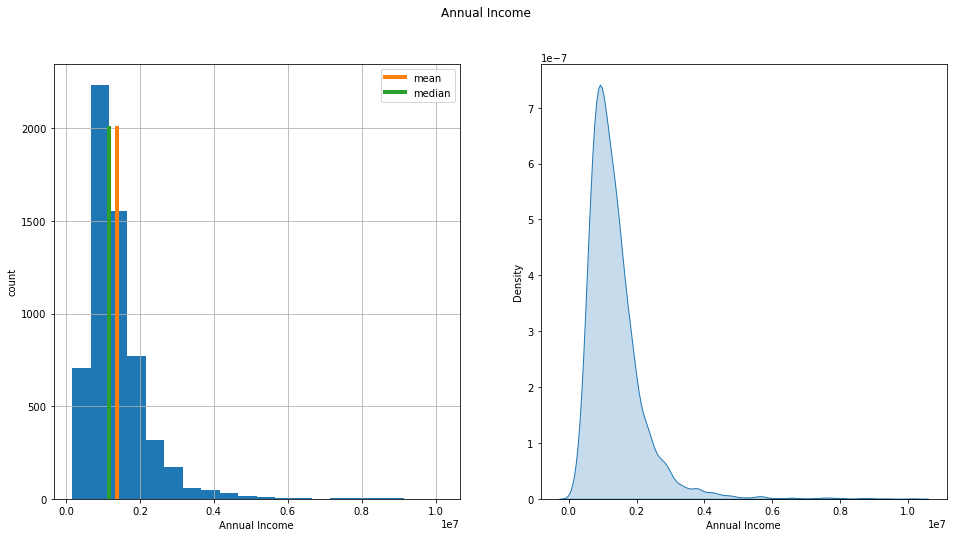

<AxesSubplot:xlabel='Annual Income'>

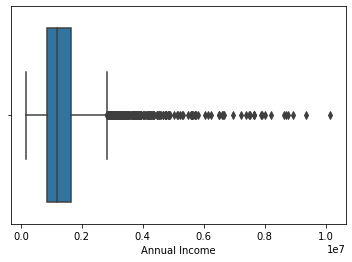

In [1460]:
s = df['Annual Income']
distribution_plot(s, 'Annual Income')
sns.boxplot(x=s, whis=1.5)

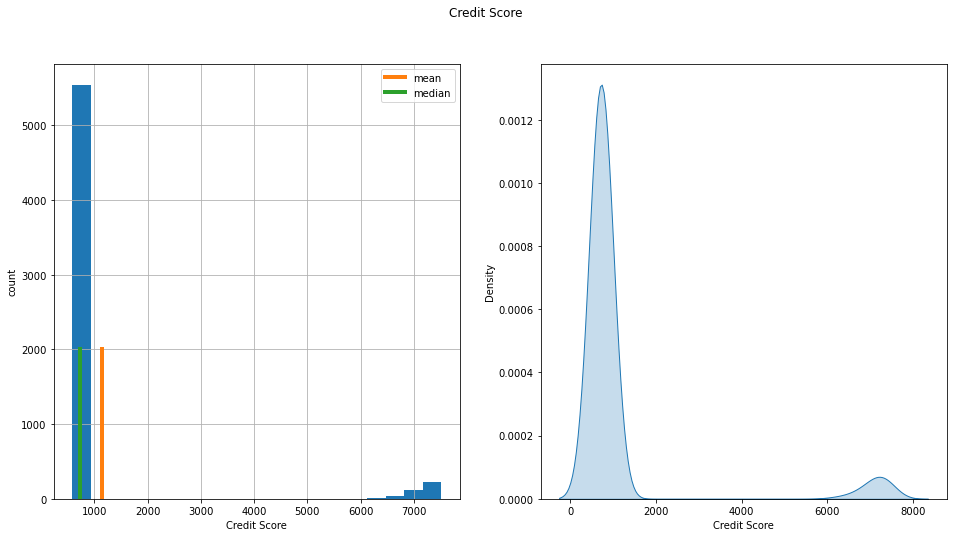

<AxesSubplot:xlabel='Credit Score'>

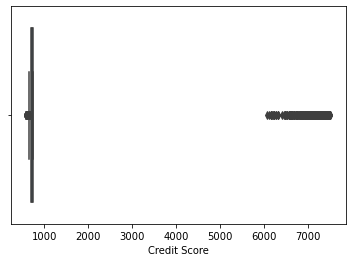

In [1461]:
s = df['Credit Score']
distribution_plot(s, 'Credit Score')
sns.boxplot(x=s, whis=1.5)

### Построение модели

**Выделение признакового описания и целевой переменной**

In [1462]:
# Применение pipeline
df = fit_trasform(df)

In [1463]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES_SELECTED = df.drop(TARGET_NAME, axis=1).columns

In [1464]:
X = df.dropna()[FEATURE_NAMES_SELECTED]
y = df.dropna()[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [1465]:
# Номинативные данные
CAT_FEATURE_NAMES = [col for col in X.columns if len(X[col].unique()) < 5] 
CAT_FEATURE_NAMES += ['Years in current job', 'Purpose']

for feature in df[CAT_FEATURE_NAMES]:
    print(feature)
    print(f'nunique: {df[feature].nunique()}')
    print(f'unique: {df[feature].unique()}\n')

Home Ownership
nunique: 4
unique: ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']

Term
nunique: 2
unique: ['Short Term' 'Long Term']

Years in current job
nunique: 12
unique: ['Not available' '10+ years' '8 years' '6 years' '7 years' '5 years'
 '1 year' '< 1 year' '4 years' '3 years' '2 years' '9 years']

Purpose
nunique: 15
unique: ['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy']



In [1466]:
scale = int(y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0])

start_model = catb.CatBoostClassifier(n_estimators=100,
                                      max_depth=4,
                                      silent=True,
                                      random_state=21,
                                      scale_pos_weight=scale)
start_model.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

y_train_pred = start_model.predict(X_train)
y_test_pred = start_model.predict(X_test)
y_test_pred_probs = start_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1816
           1       0.67      0.64      0.65       737

    accuracy                           0.81      2553
   macro avg       0.76      0.76      0.76      2553
weighted avg       0.80      0.81      0.80      2553

TEST

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       610
           1       0.58      0.55      0.56       242

    accuracy                           0.76       852
   macro avg       0.70      0.70      0.70       852
weighted avg       0.75      0.76      0.76       852

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               511   99
1               108  134


### Статистические гипотезы

In [1467]:
#  При Credit Score выше 80 (800) означает 100% невыплату кредита в следующий месяц

In [1468]:
df[df['Credit Score'] >= 80]['Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

In [1469]:
df.loc[df['Credit Score'] >= 80, 'Credit Score'] = 80

In [1470]:
# Значения -1 (Nan) и 69 признака Credit Score имеют схожие доли в разрезе целевой переменной.
credit_score_and_target_s = df.loc[df['Credit Score'].isin([69, -1]), ['Credit Score', TARGET_NAME]].sample(1000)
credit_score_and_target_s['ID'] = credit_score_and_target_s.index
table = credit_score_and_target_s.pivot_table(values='ID', index='Credit Score', columns=TARGET_NAME, aggfunc='count')
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.5062476055120265

In [1471]:
df.loc[df['Credit Score'] == -1, 'Credit Score'] = 69

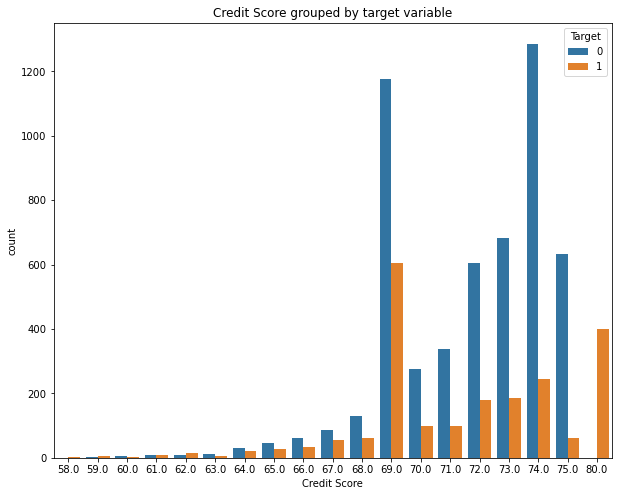

In [1472]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=df)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1473]:
# Объединение Credit Score в группы
test_df = df.copy()
values = np.sort(test_df['Credit Score'].unique())
cur = 0
end = len(values)
step = 1
while cur < end - 1:
    credit_score_and_target_s = test_df.loc[test_df['Credit Score'].isin([values[cur], values[cur+step]]), ['Credit Score', TARGET_NAME]]
    credit_score_and_target_s['ID'] = credit_score_and_target_s.index
    table = credit_score_and_target_s.pivot_table(values='ID', index='Credit Score', columns=TARGET_NAME, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    if p > 0.05:
        step += 1
        if values[cur] != values[cur+step-1]:
            print(f'{values[cur]} - {values[cur+step-1]}: {p}')
    else:
        step = 1
        cur += 1

59.0 - 60.0: 0.15729920705028105
59.0 - 61.0: 0.5003523731064727
59.0 - 62.0: 0.7607052535729718
59.0 - 63.0: 0.11265420391072284
59.0 - 64.0: 0.1517713778190382
59.0 - 65.0: 0.08667881530421268
59.0 - 66.0: 0.08013671220850635
59.0 - 67.0: 0.09573977776149899
60.0 - 61.0: 0.34001781862566155
60.0 - 62.0: 0.16048496760673192
60.0 - 63.0: 0.9303862304862558
60.0 - 64.0: 0.6731680802431669
60.0 - 65.0: 0.8300239094161025
60.0 - 66.0: 0.8345065284596327
60.0 - 67.0: 0.7539650179785697
60.0 - 68.0: 0.9216606177053657
60.0 - 69.0: 0.9669704664204157
60.0 - 70.0: 0.6379896298691367
60.0 - 71.0: 0.46152049516701055
60.0 - 72.0: 0.45486097948858173
60.0 - 73.0: 0.38870450480675234
60.0 - 74.0: 0.15655266386470537
61.0 - 62.0: 0.6160647788983531
61.0 - 63.0: 0.2722936273128258
61.0 - 64.0: 0.3854476659307856
61.0 - 65.0: 0.226527965402805
61.0 - 66.0: 0.21066338952640729
61.0 - 67.0: 0.25368668716780707
61.0 - 68.0: 0.07628895424085406
61.0 - 69.0: 0.10104239263779315
62.0 - 63.0: 0.09051162675

In [1474]:
df.loc[df['Credit Score'].between(0, 64), 'Credit Score'] = 64
df.loc[df['Credit Score'].between(65, 69), 'Credit Score'] = 69
df.loc[df['Credit Score'].between(71, 73), 'Credit Score'] = 73

In [1475]:
df['Credit Score'].value_counts()

69.0    2280
73.0    2089
74.0    1530
75.0     697
80.0     400
70.0     376
64.0     128
Name: Credit Score, dtype: int64

In [1476]:
# Months since last delinquent
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1

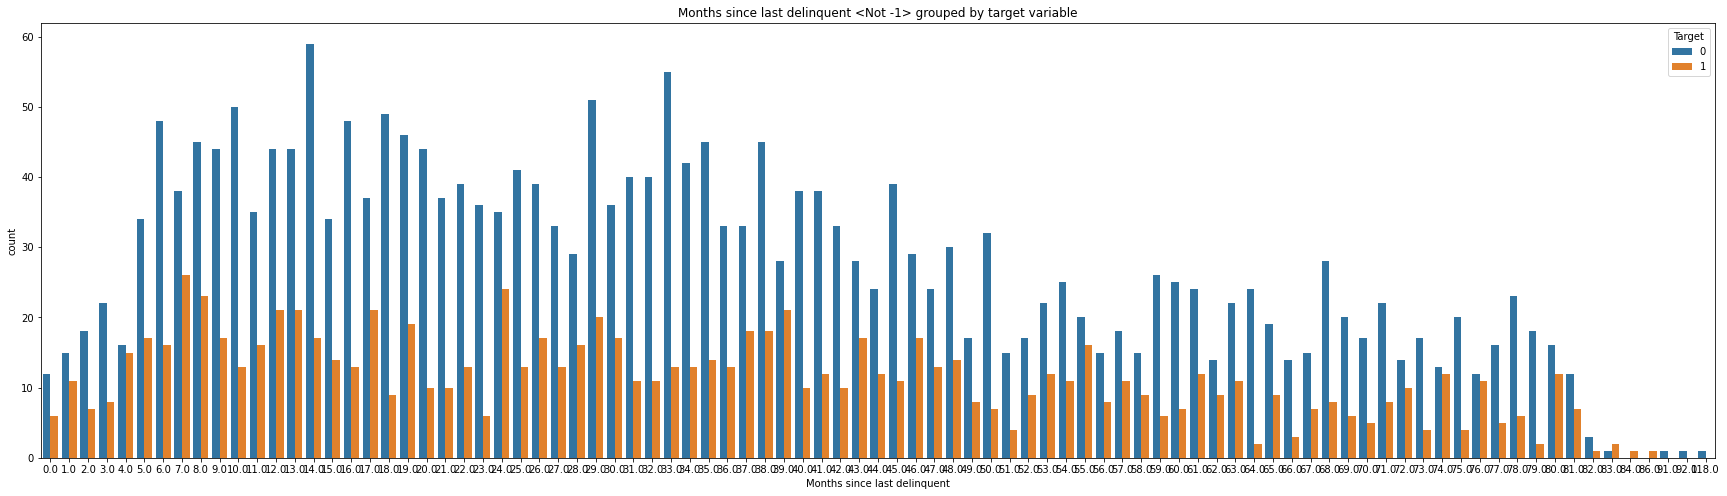

In [1477]:
plt.figure(figsize=(30, 8))

sns.countplot(x="Months since last delinquent", hue=TARGET_NAME, data=df.loc[df['Months since last delinquent'] != -1])
plt.title('Months since last delinquent <Not -1> grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

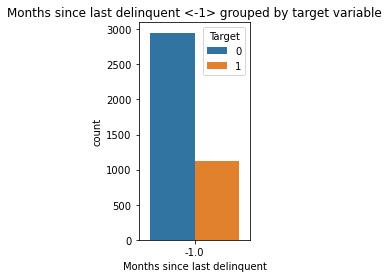

In [1478]:
plt.figure(figsize=(2, 4))

sns.countplot(x="Months since last delinquent", hue=TARGET_NAME, data=df.loc[df['Months since last delinquent'] == -1])
plt.title('Months since last delinquent <-1> grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1479]:
# Визуально, -1 ближе всего к 6. Проверка:
credit_score_and_target_s = df.loc[df['Months since last delinquent'].isin([6, -1]), ['Months since last delinquent', TARGET_NAME]]
credit_score_and_target_s['ID'] = credit_score_and_target_s.index
table = credit_score_and_target_s.pivot_table(values='ID', index='Months since last delinquent', columns=TARGET_NAME, aggfunc='count')
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.6331473294874655

In [1480]:
df.loc[df['Months since last delinquent'] == -1, 'Months since last delinquent'] = 6

#### Важность признаков

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


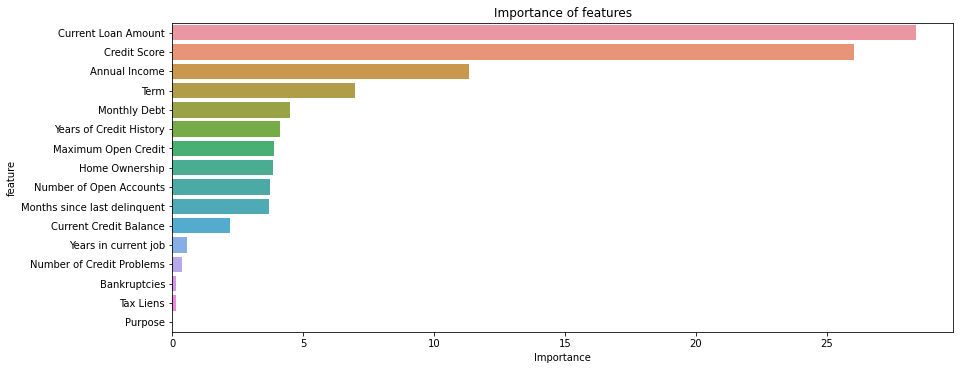

In [1481]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  start_model.feature_importances_, 
                                                  get_top=15)

In [1482]:
# С помощью экспериментов удалось выявить признаки, которые понижают f1:
#   'Bankruptcies', 'Purpose', 'Years in current job'

In [1483]:
df.drop(columns=['Bankruptcies', 'Purpose', 'Years in current job'], axis=1, inplace=True)

In [1484]:
FEATURE_NAMES_SELECTED = df.drop(TARGET_NAME, axis=1).columns

X = df.dropna()[FEATURE_NAMES_SELECTED]
y = df.dropna()[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

CAT_FEATURE_NAMES = [col for col in X.columns if len(X[col].unique()) < 5]

model = catb.CatBoostClassifier(n_estimators=100,
                                max_depth=4,
                                silent=True,
                                random_state=21,
                                scale_pos_weight=scale)
model.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred_probs = model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4047
           1       0.61      0.60      0.60      1578

    accuracy                           0.78      5625
   macro avg       0.73      0.73      0.73      5625
weighted avg       0.78      0.78      0.78      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1340
           1       0.56      0.53      0.54       535

    accuracy                           0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1116  224
1                254  281


### Дополнительный анализ

In [1485]:
# Другие теории:
# Years in current job: заполнить пропуски 0 years - f1 повысилось
# Years in current job: заполнить пропуски < 1 years - не подтвердилась, f1 понизилось
# Credit_Score можно вычислить по другим признакам - не подтвердилась, см. Credit_Score.ipynb
# Новый признак, дельта = (Annual Income / 12 + Current Credit Balance) / Monthly Debt - не подвердилась, причем в разных комбинациях
# 

**Обзор распределения**

In [1486]:
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

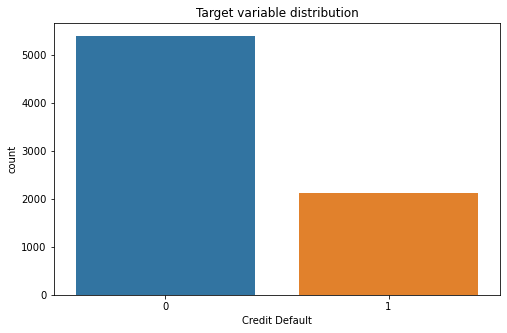

In [1487]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

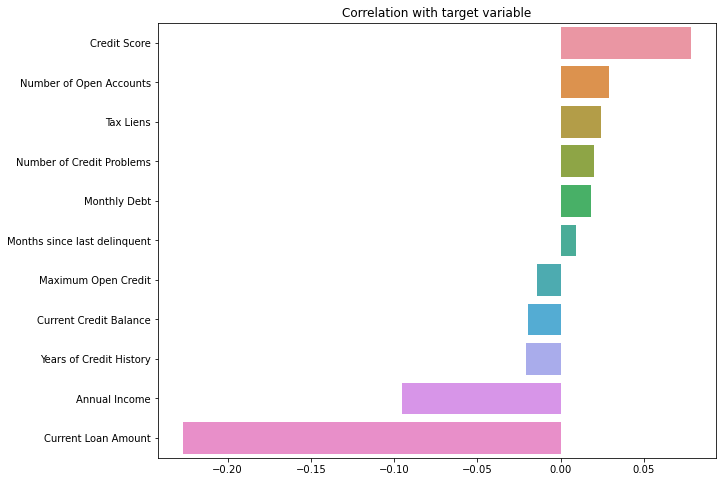

In [1488]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Проверка альтернативных моделей

In [1489]:
import xgboost as xgb
import lightgbm as lgbm
from sklearn import preprocessing

In [1490]:
FEATURE_NAMES_SELECTED = df.drop(TARGET_NAME, axis=1).columns

X = df.dropna()[FEATURE_NAMES_SELECTED]
y = df.dropna()[TARGET_NAME]

cat_features = ['Home Ownership', 'Term']

In [1491]:
lbl = preprocessing.LabelEncoder()
for feature in cat_features:
    X[feature] = lbl.fit_transform(X[feature].astype(str))
    X[feature] = lbl.fit_transform(X[feature].astype(str))

In [1492]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [1493]:
model_xgb = xgb.XGBClassifier(random_state=21, enable_categorical=True)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:50:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4047
           1       1.00      0.83      0.91      1578

    accuracy                           0.95      5625
   macro avg       0.97      0.92      0.94      5625
weighted avg       0.95      0.95      0.95      5625

TEST

        

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


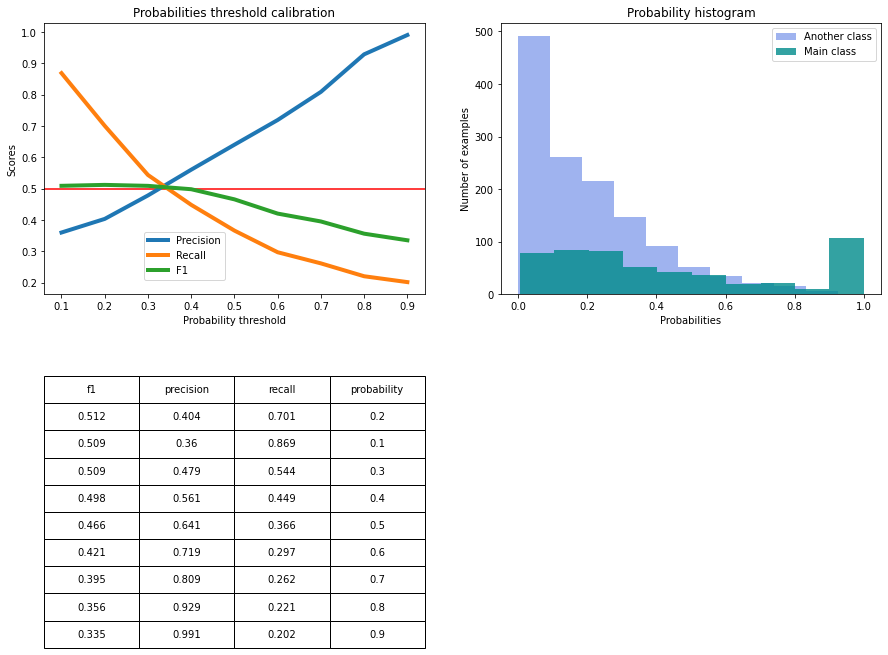

In [1494]:
y_test_pred_probs = model_xgb.predict_proba(X_test)[:, 1]
show_proba_calibration_plots(y_test_pred_probs, y_test)

In [1495]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4047
           1       0.98      0.65      0.78      1578

    accuracy                           0.90      5625
   macro avg       0.93      0.82      0.86      5625
weighted avg       0.91      0.90      0.89      5625

TEST

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1340
           1       0.70      0.33      0.44       535

    accuracy                           0.77      1875
   macro avg       0.74      0.64      0.65      1875
weighted avg       0.76      0.77      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1266   74
1                361  174


#### Вывод: CatBoost ok

#### Подбор гиперпараметров CatBoost

In [1496]:
from catboost import Pool

model_catb = catb.CatBoostClassifier(n_estimators=100,
                                     custom_loss=['F1'],
                                     silent=True, 
                                     random_state=21)
grid = {
    'learning_rate': np.arange(0.02, 0.06, 0.01),
    'depth':[6, 7, 8],
    #'l2_leaf_reg': [0.07, 0.08, 0.09]
}
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

grid_search_results = model_catb.grid_search(grid, train_pool, cv=3, stratified=True,
                                             verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4693409669
bestIteration = 99


bestTest = 0.4664793696
bestIteration = 98


bestTest = 0.4622183901
bestIteration = 99


bestTest = 0.4617794109
bestIteration = 97


bestTest = 0.4708734256
bestIteration = 99


bestTest = 0.4629352892
bestIteration = 97


bestTest = 0.4610179236
bestIteration = 95


bestTest = 0.4607076254
bestIteration = 92


bestTest = 0.4726549084
bestIteration = 99


bestTest = 0.4662472357
bestIteration = 98


bestTest = 0.4612755407
bestIteration = 97


bestTest = 0.4625521284
bestIteration = 98



#### Сравнение моделей CatBoost

In [1497]:
model1 = catb.CatBoostClassifier(
    n_estimators=100,
    max_depth=4,
    custom_loss=['F1'],
    random_state=21,
    train_dir='1',
    scale_pos_weight=scale
)

model2 = catb.CatBoostClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.04,
    custom_loss=['F1'],
    random_state=21,
    train_dir='2',
    scale_pos_weight=scale
)
model1.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose=False
)

from catboost import MetricVisualizer

MetricVisualizer(['1', '2']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Вывод: подобранные гипперпараметры ухудшили F1. Не используем.

In [1498]:
FEATURE_NAMES_SELECTED = df.drop(TARGET_NAME, axis=1).columns

X = df.dropna()[FEATURE_NAMES_SELECTED]
y = df.dropna()[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

CAT_FEATURE_NAMES = [col for col in X.columns if len(X[col].unique()) < 5]

model = catb.CatBoostClassifier(
    n_estimators=100,
    max_depth=4,
    custom_loss=['F1'],
    random_state=21,
    scale_pos_weight=scale,
    silent=True
)
model.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred_probs = model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4047
           1       0.61      0.60      0.60      1578

    accuracy                           0.78      5625
   macro avg       0.73      0.73      0.73      5625
weighted avg       0.78      0.78      0.78      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1340
           1       0.56      0.53      0.54       535

    accuracy                           0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1116  224
1                254  281


### Финальный pipeline

In [1499]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.annual_incom_median = None
        
    def fit(self, df):
        """Сохранение статистик"""
        self.annual_incom_median = df['Annual Income'].median()
        
    def transform(self, df):
        """Трансформация данных"""
        
        df['Credit Score'] /= 10
        df['Credit Score'] = df['Credit Score'].round()
        
        # Пропуски
        df['Years in current job'].fillna(value='Not available', inplace=True)
        
        df['Annual Income'].fillna(value=median, inplace=True)
        df['Credit Score'].fillna(value=69, inplace=True)
        
        df.loc[df['Credit Score'] >= 80, 'Credit Score'] = 80
        
        df.loc[df['Credit Score'].between(0, 64), 'Credit Score'] = 64
        df.loc[df['Credit Score'].between(65, 69), 'Credit Score'] = 69
        df.loc[df['Credit Score'].between(71, 73), 'Credit Score'] = 73
        
        df['Months since last delinquent'].fillna(value=6, inplace=True)
        
        df.drop(columns=['Bankruptcies', 'Purpose', 'Years in current job'], axis=1, inplace=True)
        
        return df

def fit_trasform(df):
    pipe = DataPipeline()
    pipe.fit(df)
    return pipe.transform(df)

### Построение финальной модели

**Выделение признакового описания и целевой переменной**

In [1500]:
df = fit_trasform(pd.read_csv(TRAIN_DATASET_PATH))

In [1501]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES_SELECTED = df.drop(TARGET_NAME, axis=1).columns

In [1502]:
X = df.dropna()[FEATURE_NAMES_SELECTED]
y = df.dropna()[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [1503]:
# Номинативные данные
CAT_FEATURE_NAMES = [col for col in X.columns if len(X[col].unique()) < 5]

In [1507]:
scale = int(y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0])

final_model = catb.CatBoostClassifier(n_estimators=100,
                                      max_depth=4,
                                      silent=True,
                                      random_state=21,
                                      scale_pos_weight=scale)
final_model.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4047
           1       0.61      0.60      0.60      1578

    accuracy                           0.78      5625
   macro avg       0.73      0.73      0.73      5625
weighted avg       0.78      0.78      0.78      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1340
           1       0.56      0.53      0.54       535

    accuracy                           0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1116  224
1                254  281


### Подбор вероятности

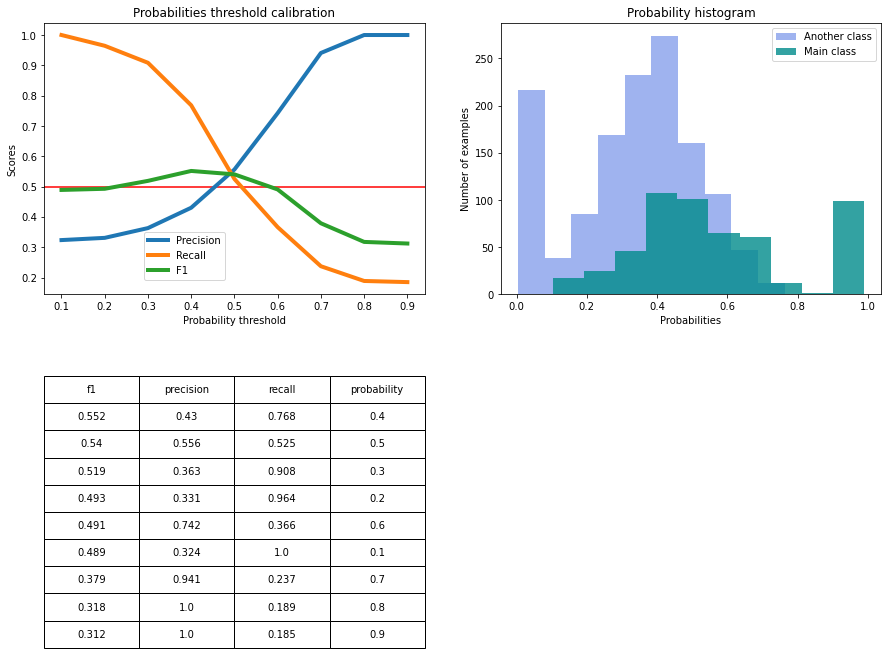

In [1508]:
y_test_pred_probs = final_model.predict_proba(X_test)[:, 1]
show_proba_calibration_plots(y_test_pred_probs, y_test)

In [1506]:
# При probality ~= 0.49 результат оптимальный

### Сохранение финальной модели и предсказаний

In [1511]:
import pickle

with open("model.pkl", 'wb') as file:
    pickle.dump(final_model, file)

In [1512]:
y_test_labels = np.array(y_test_pred_probs > 0.49, dtype=int)
pd.DataFrame(y_test_labels).to_csv('predictions.csv', header=None, index=None)